# L4. Fast SLAM 

### Define all the imports

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Change to main repo folder for the imports
_, dir = os.path.split(os.getcwd())
if dir == 'notebooks': 
    os.chdir('..')
    sys.path.append(os.getcwd())
pd.set_option('mode.chained_assignment', None)

In [6]:
from src.fast_SLAM_1.Fast_SLAM_1_unknown_correspondences import FastSLAM1 as FastSLAM1
from src.fast_SLAM_1.lib import MotionModel as FS1_MotionModel
from src.fast_SLAM_1.lib import MeasurementModel as FS1_MeasurementModel

from src.fast_SLAM_2.Fast_SLAM_2_unknown_correspondences import FastSLAM2 as FastSLAM2
from src.fast_SLAM_2.lib import MotionModel as FS2_MotionModel
from src.fast_SLAM_2.lib import MeasurementModel as FS2_MeasurementModel


### Set dataset

In [7]:
# Define dataset to read
dataset = "data/MRCLAM_Dataset1"
robot = 'Robot1' # Robot
start_frame = 2000
end_frame = 16000

### T1. Execute Fast SLAM 1
Test different datasets and analyze the performance of the algorithm

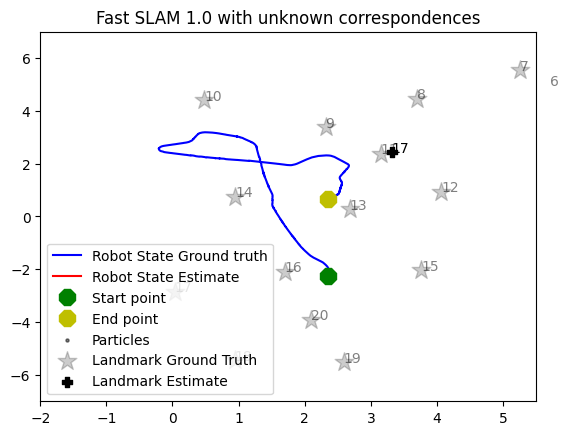

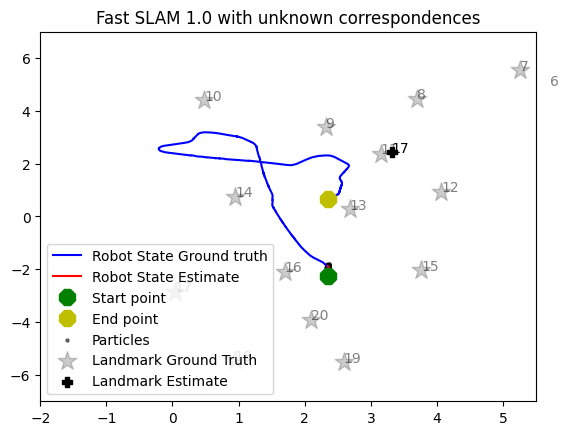

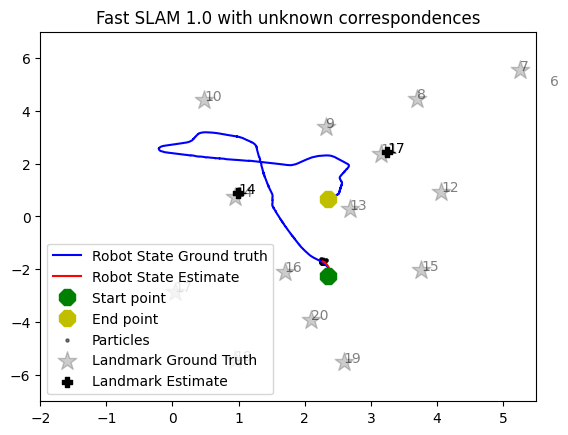

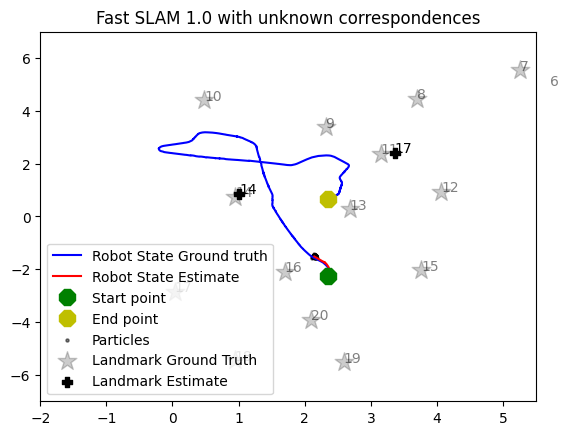

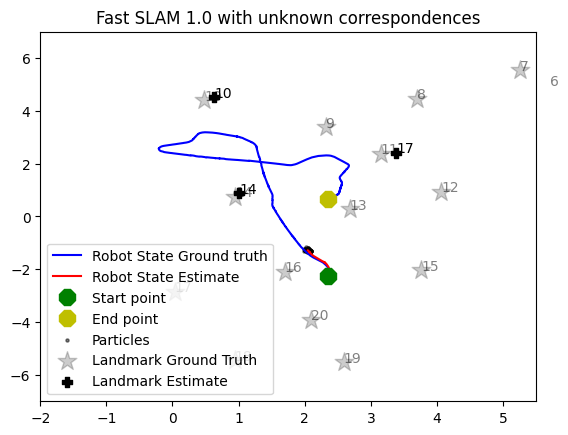

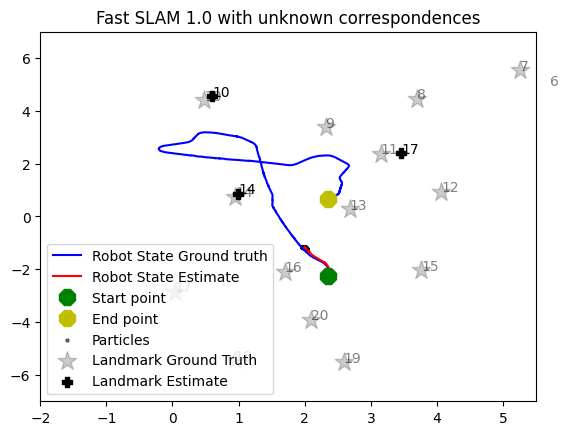

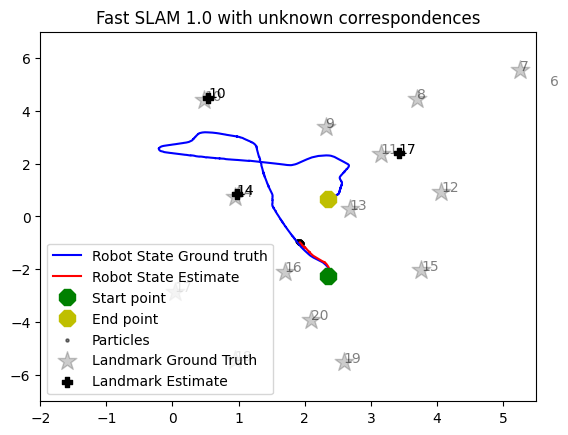

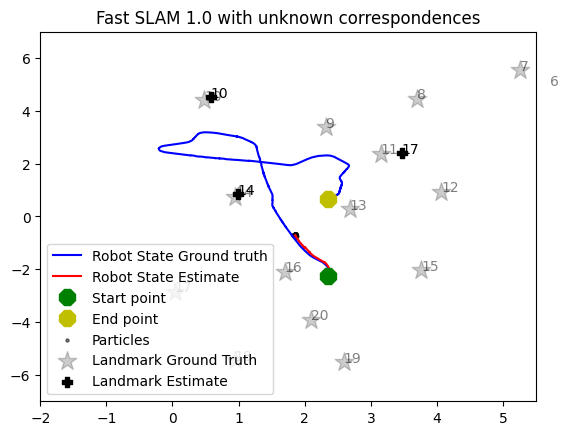

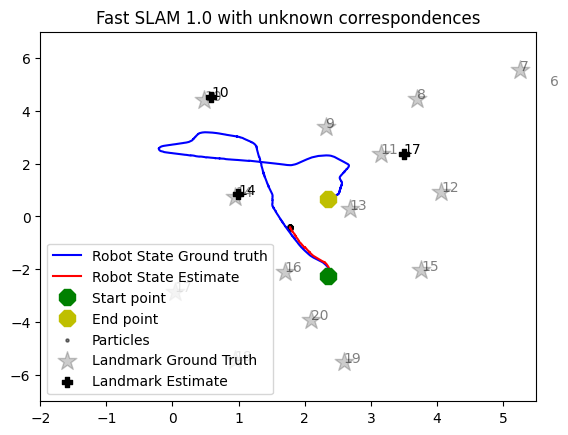

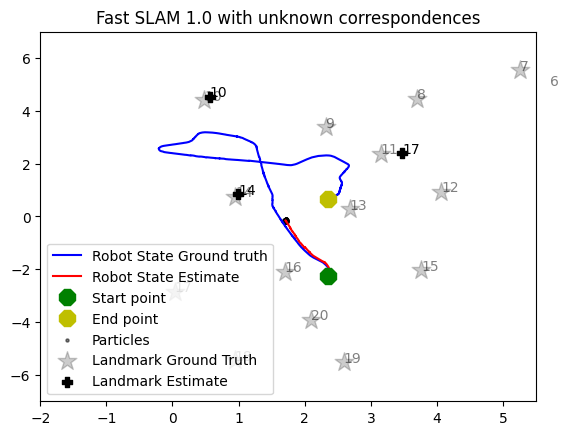

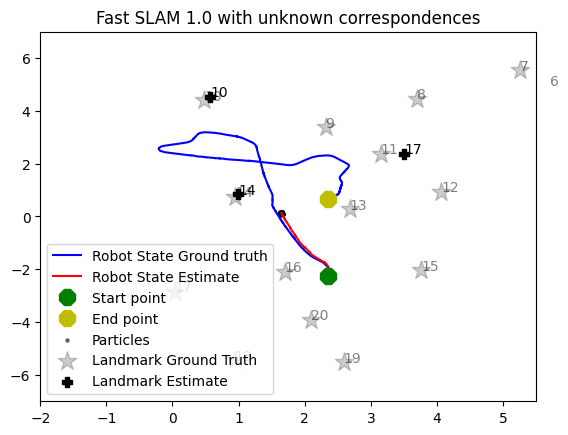

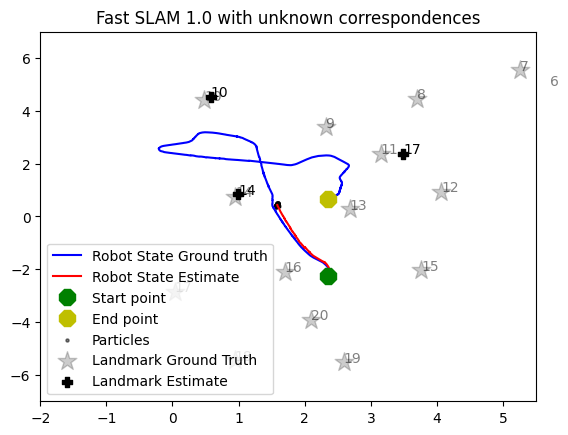

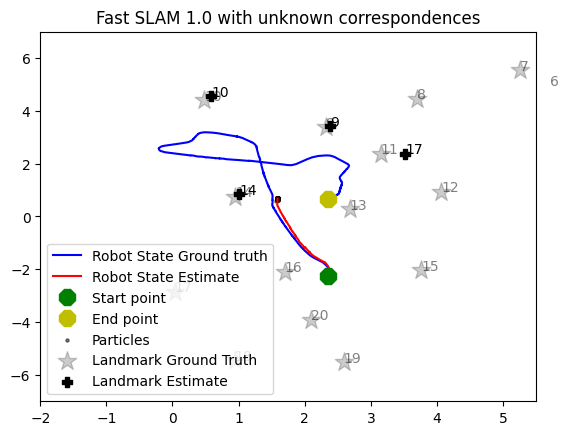

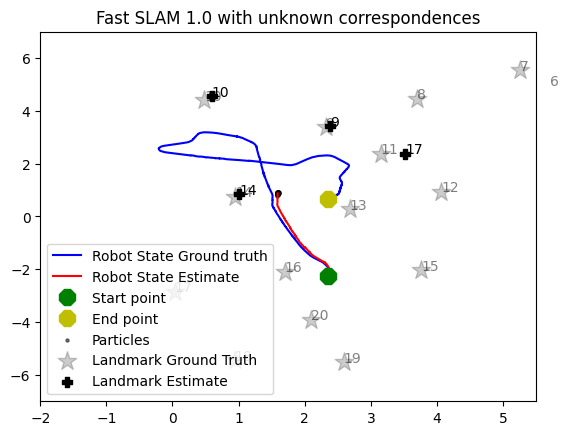

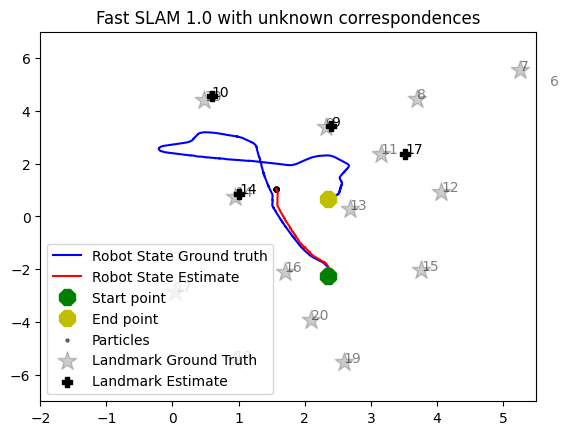

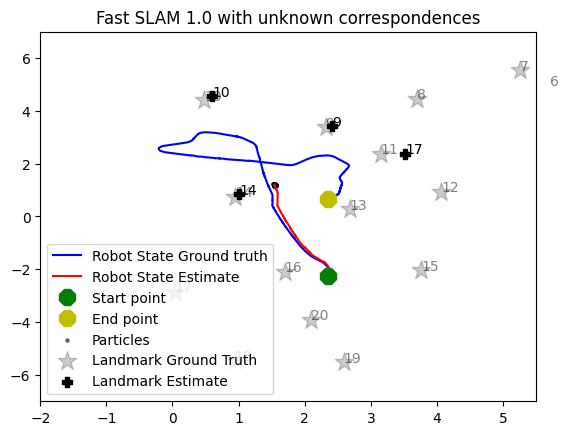

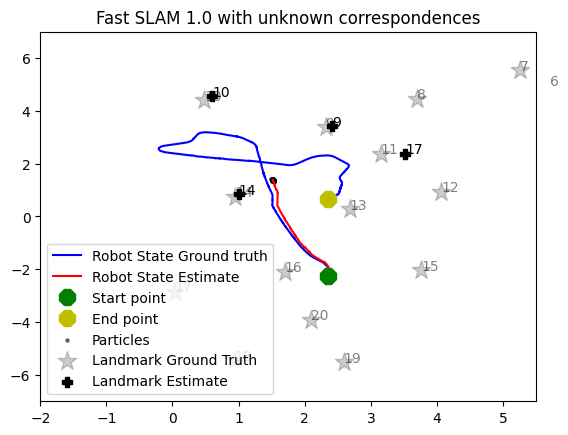

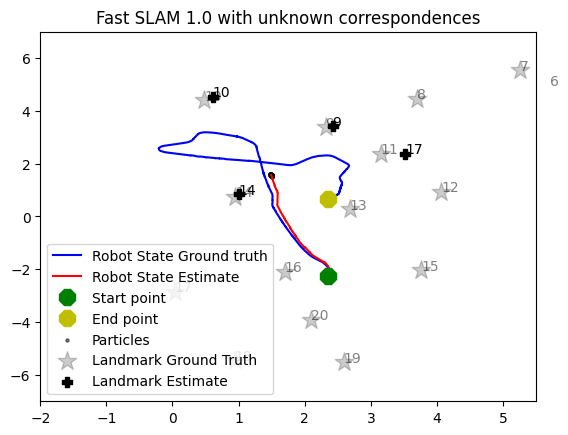

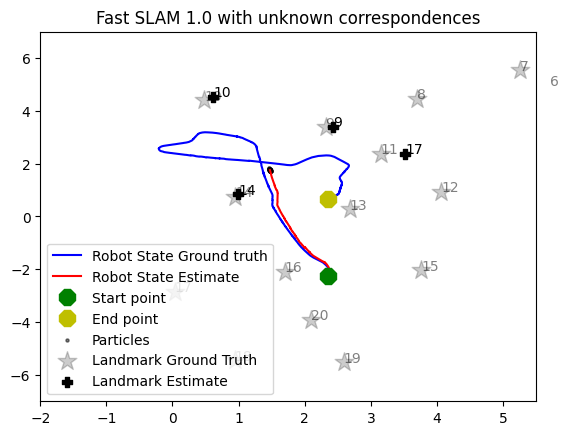

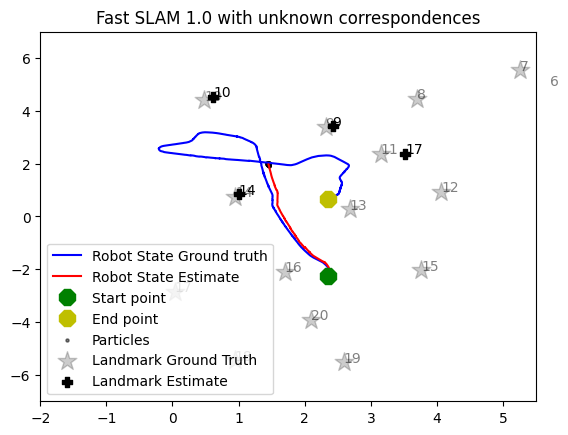

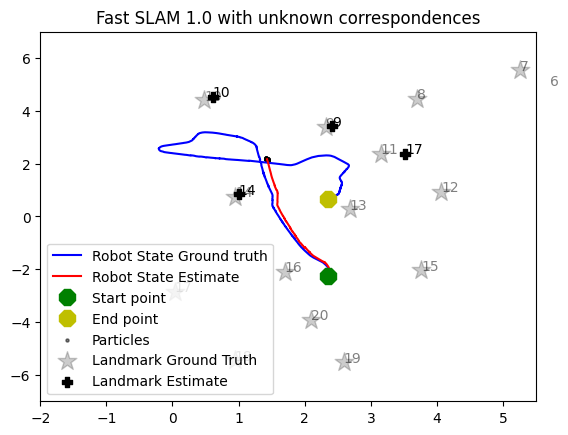

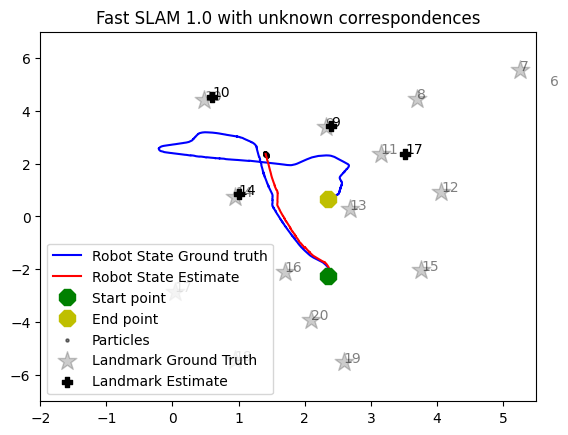

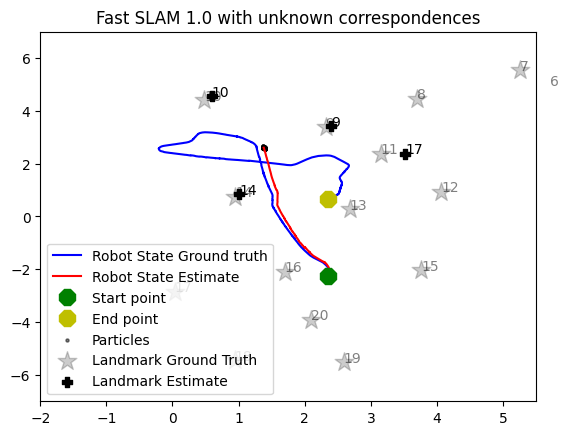

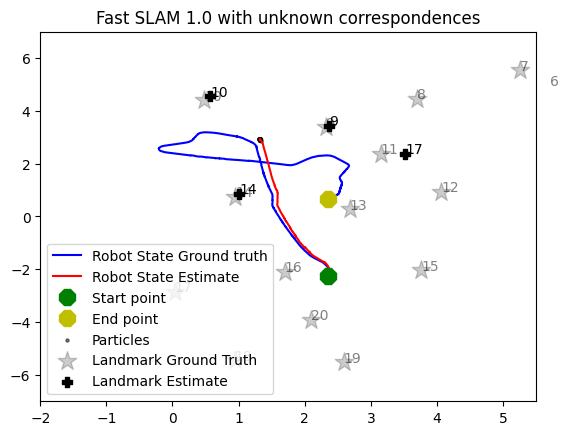

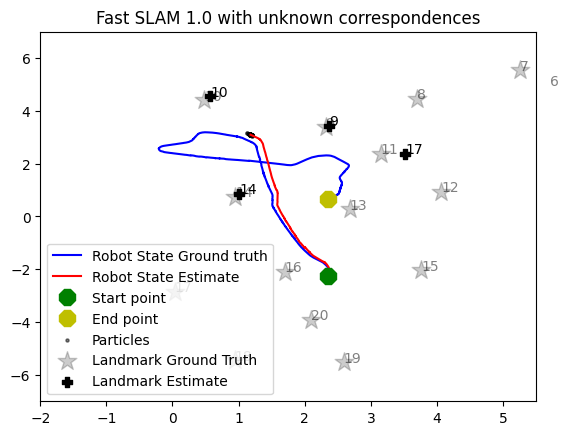

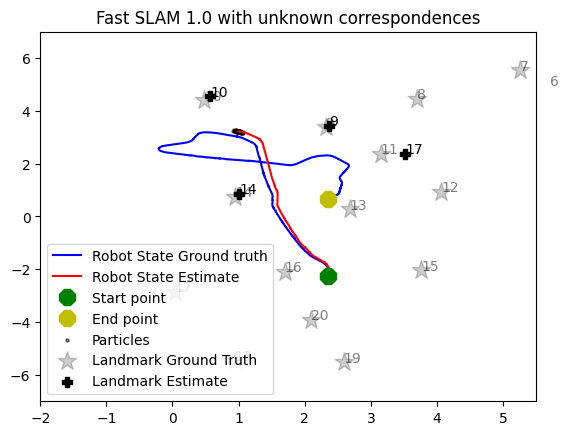

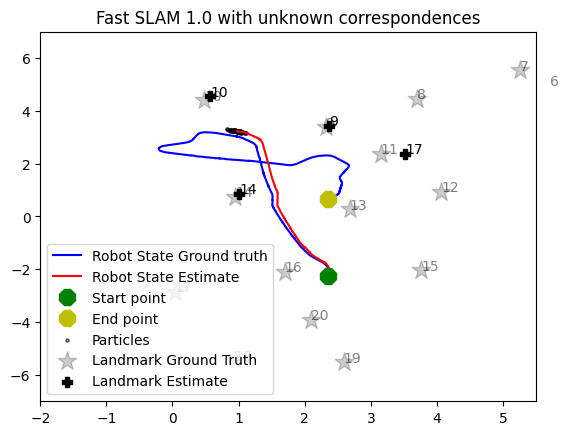

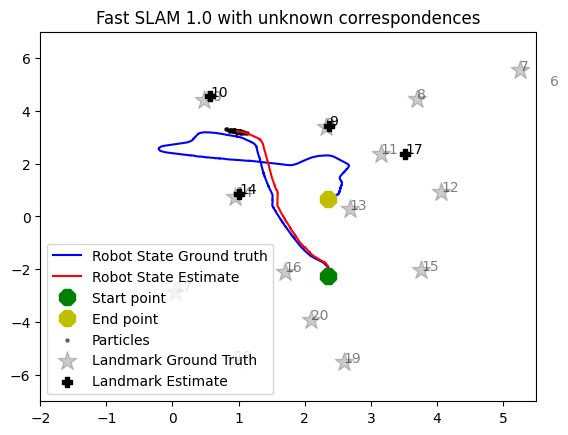

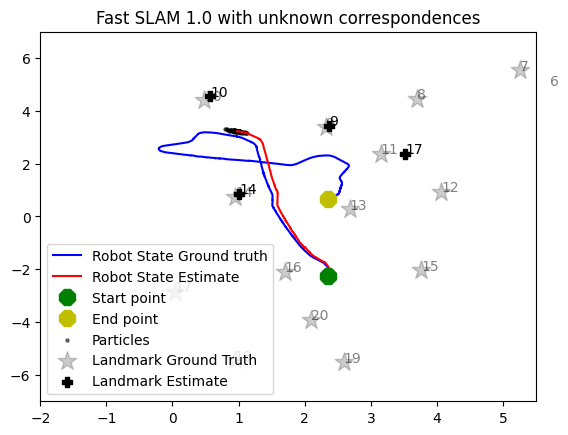

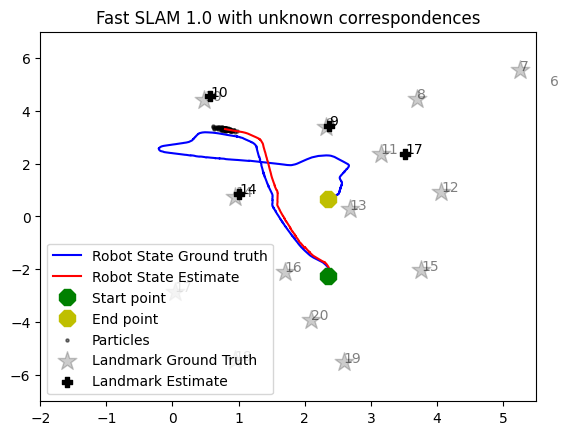

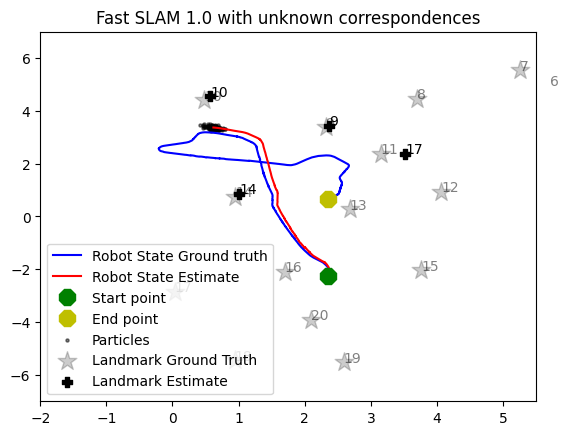

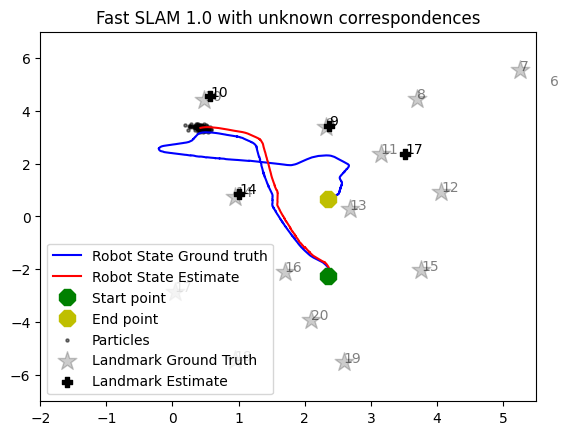

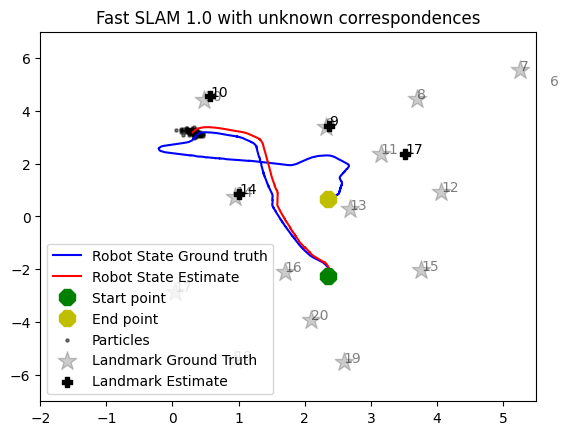

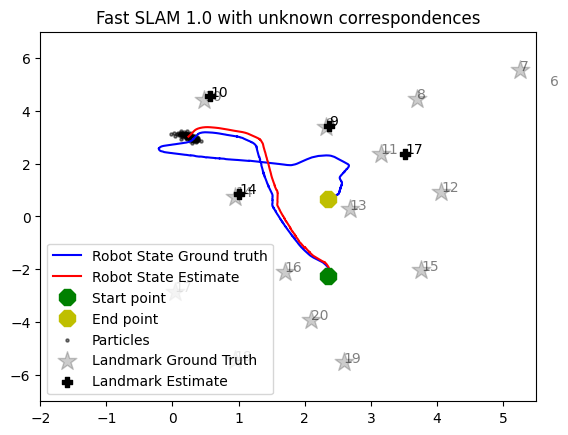

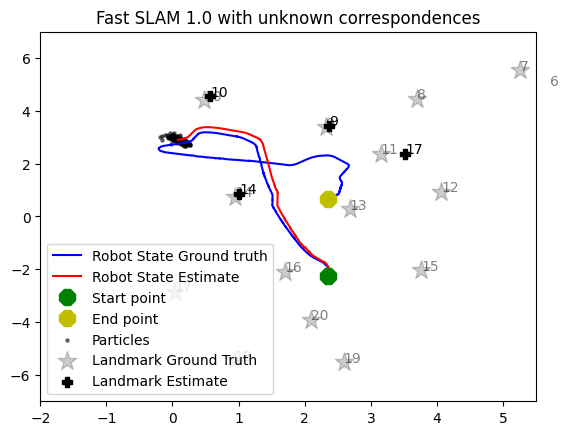

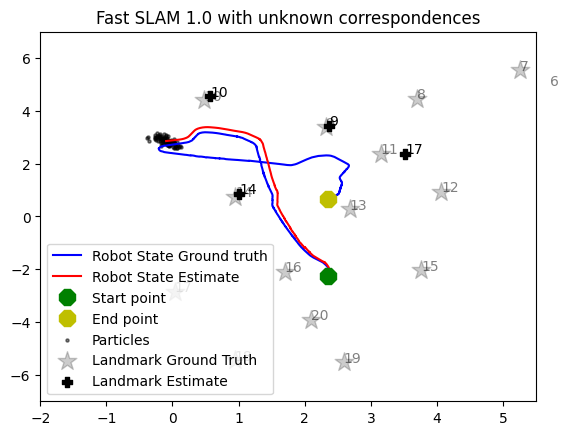

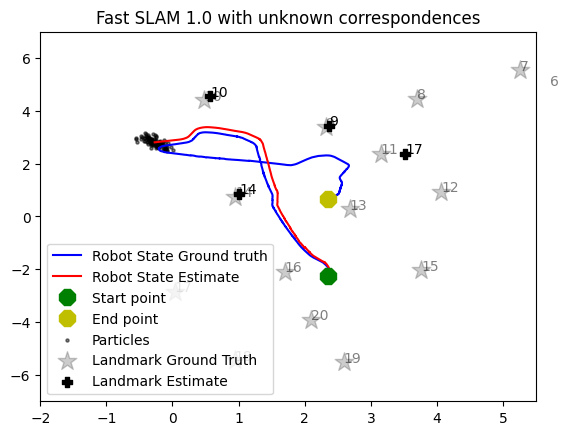

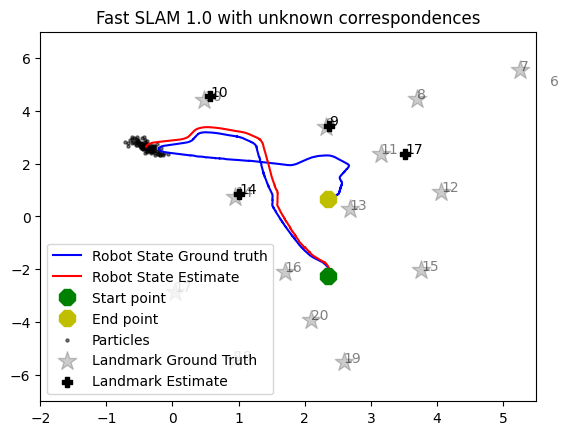

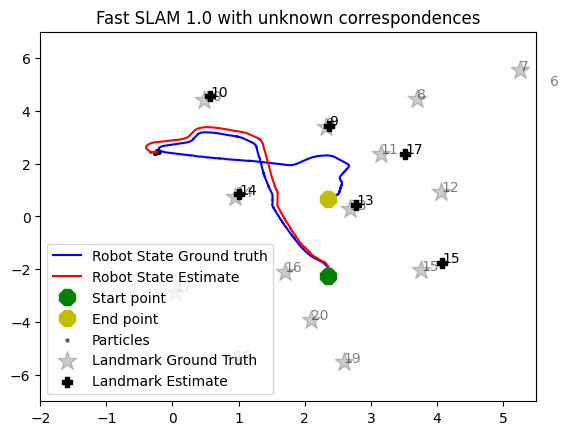

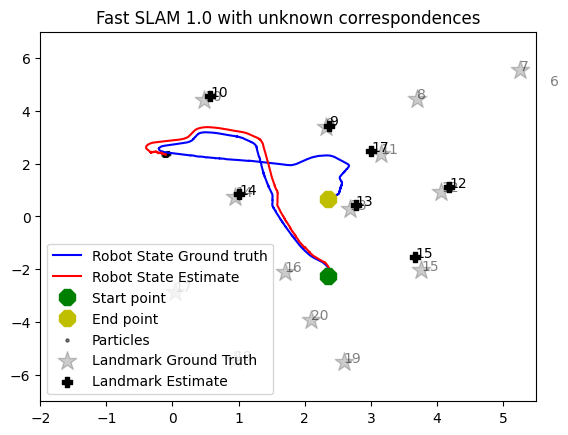

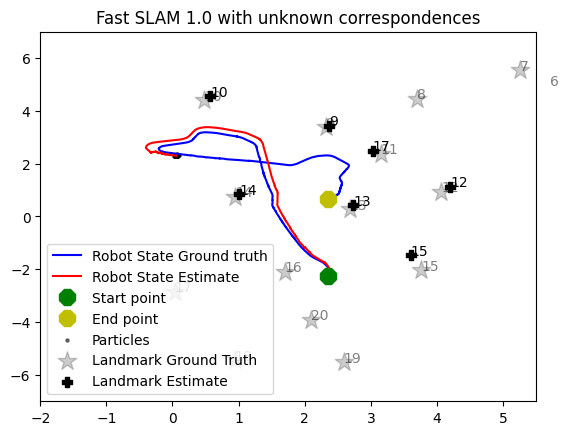

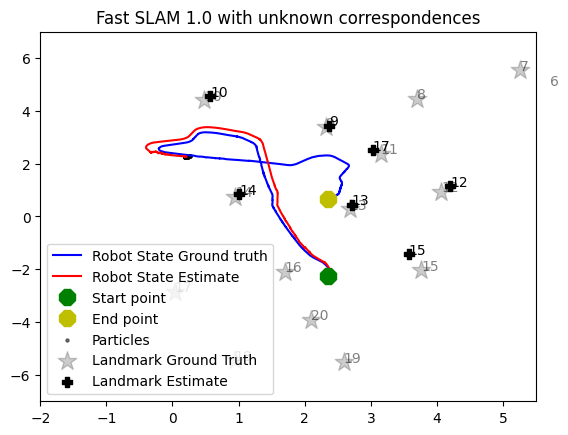

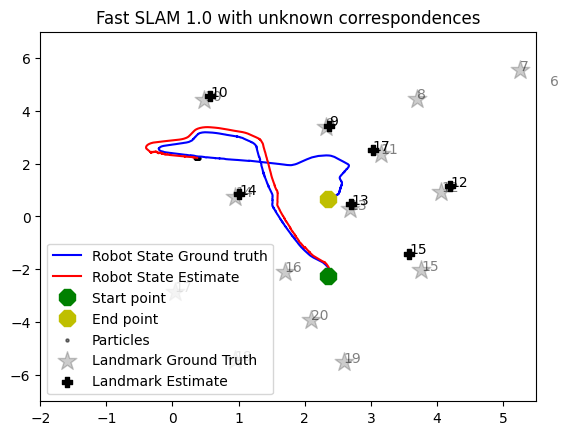

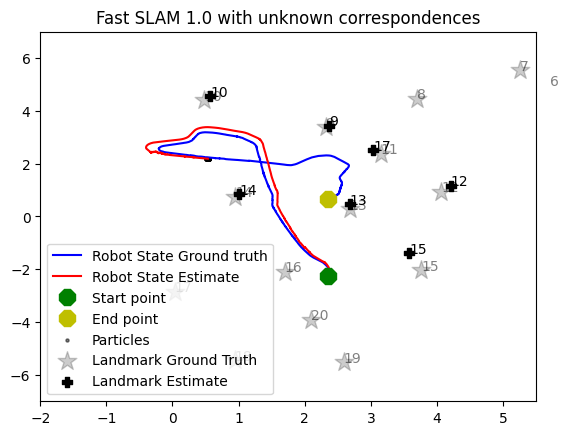

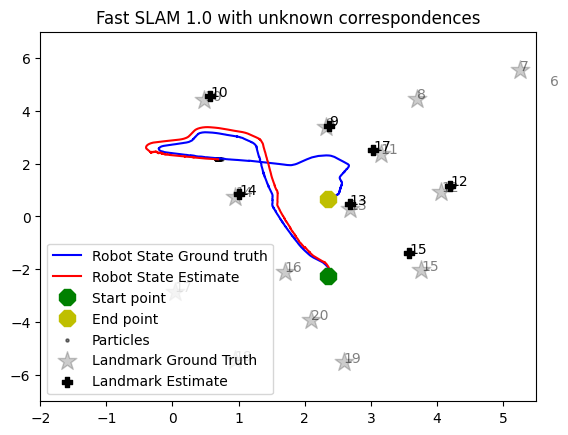

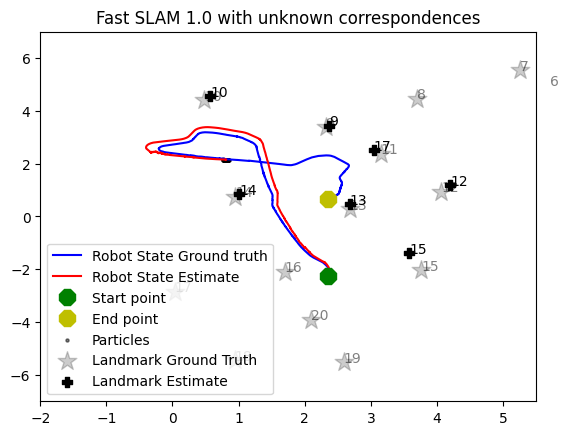

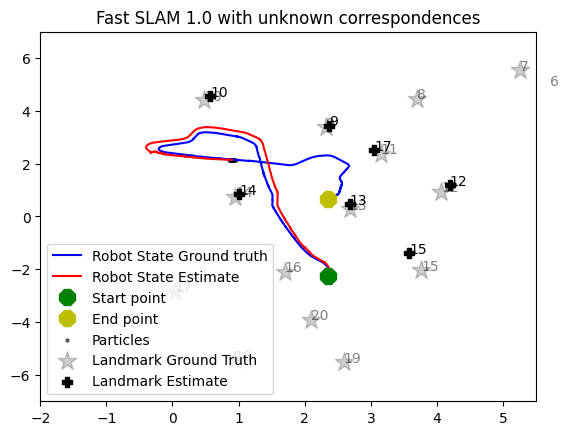

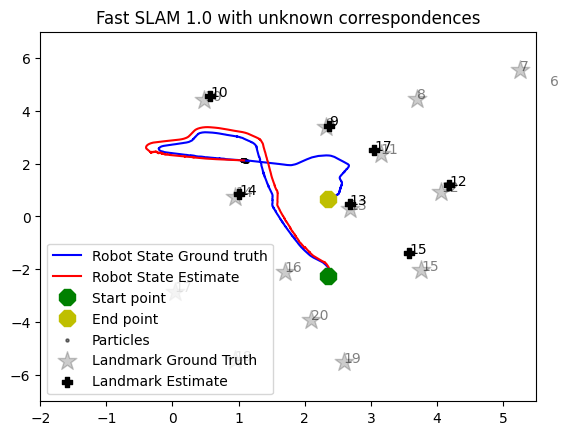

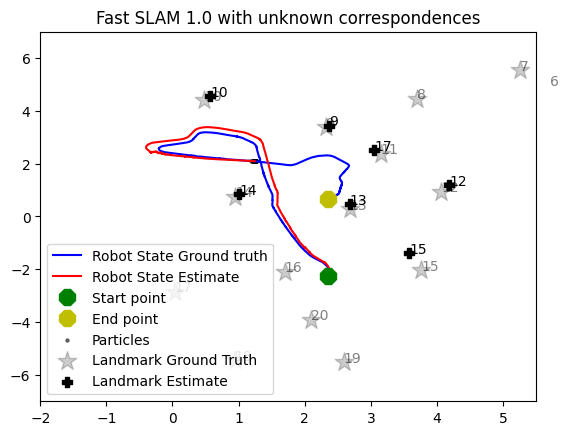

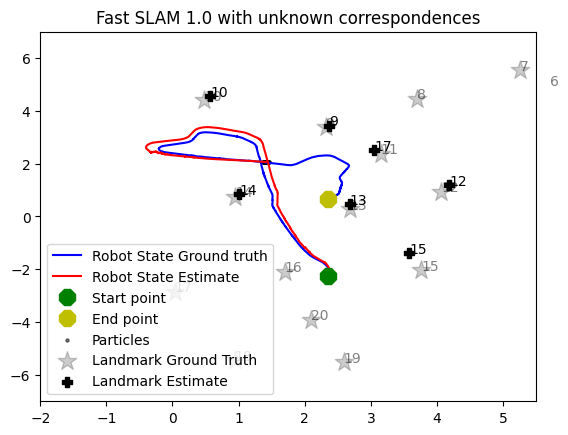

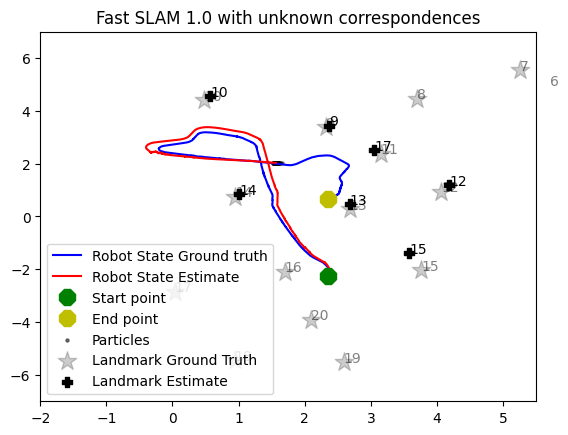

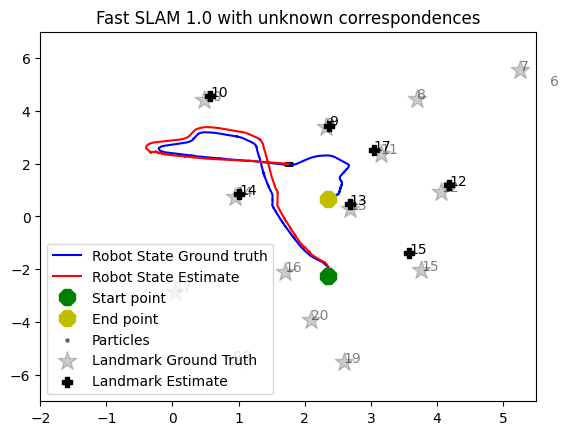

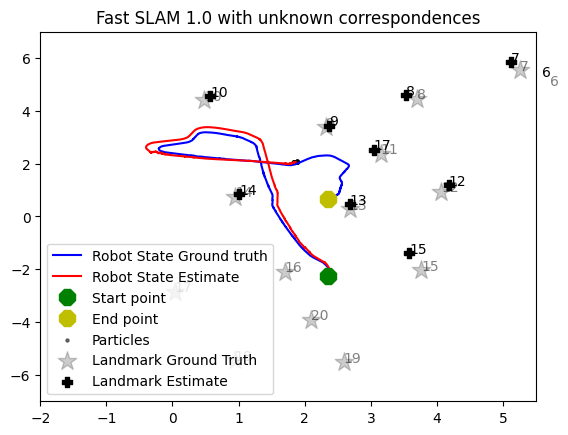

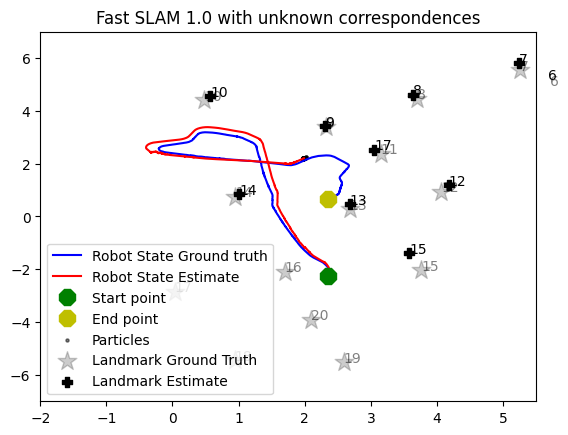

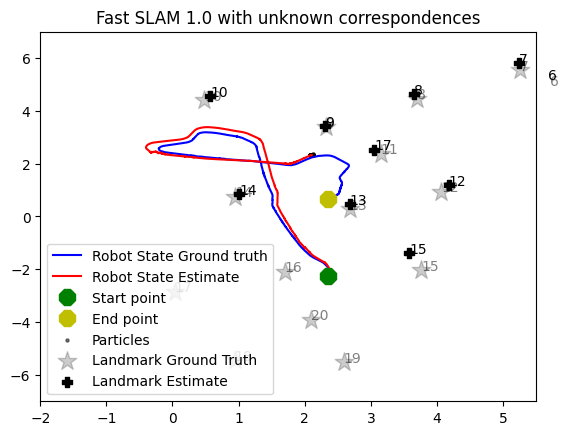

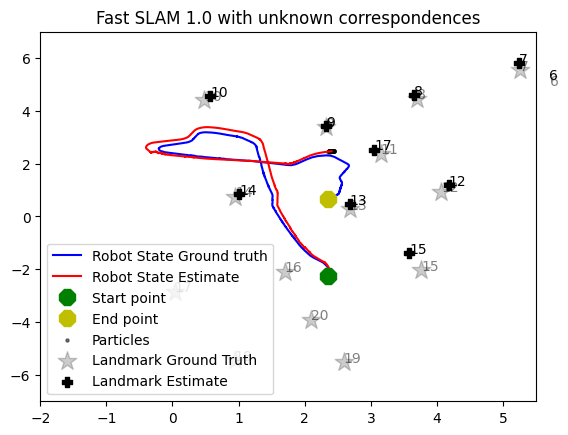

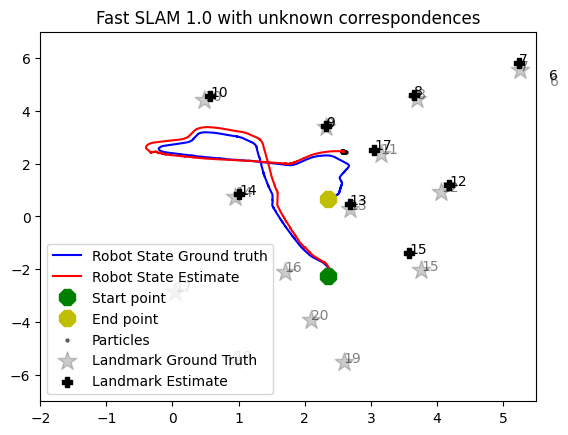

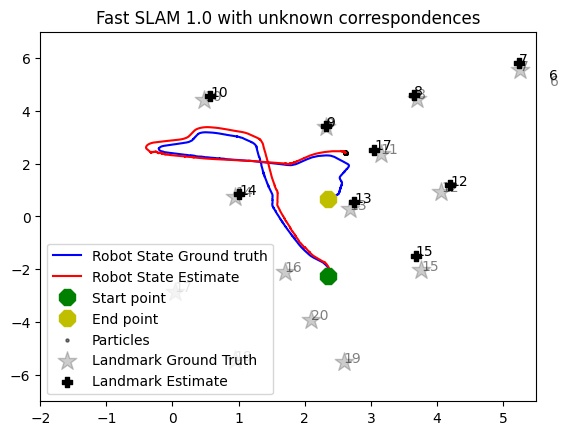

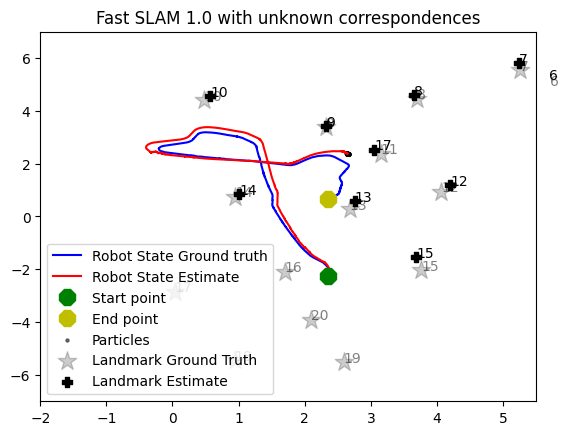

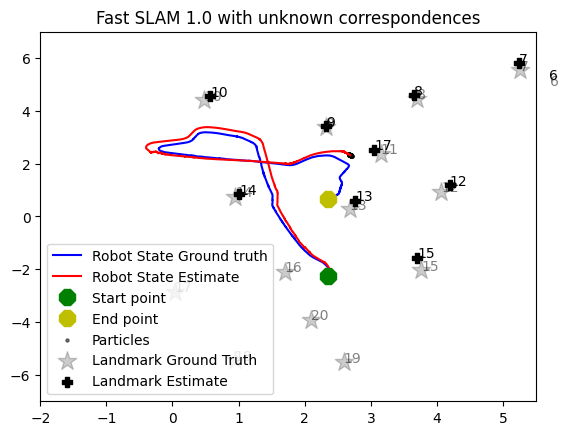

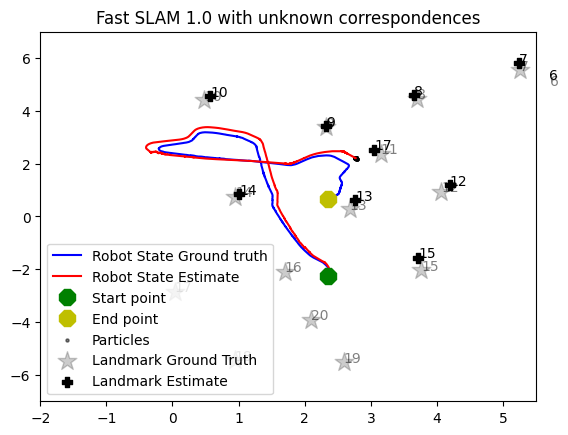

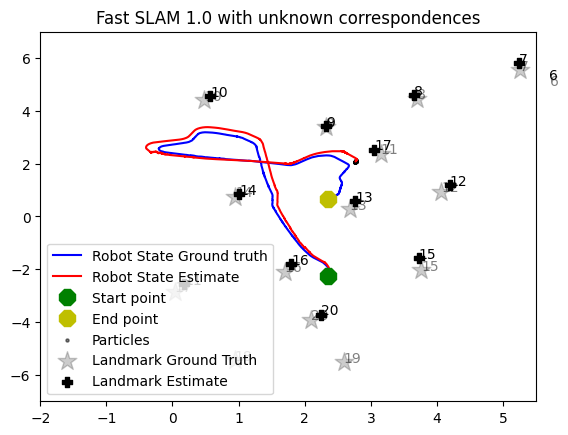

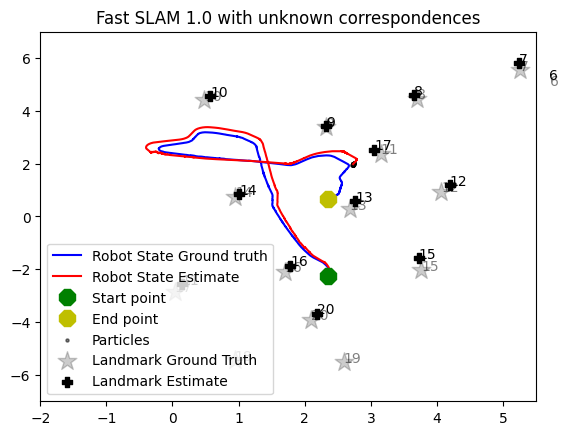

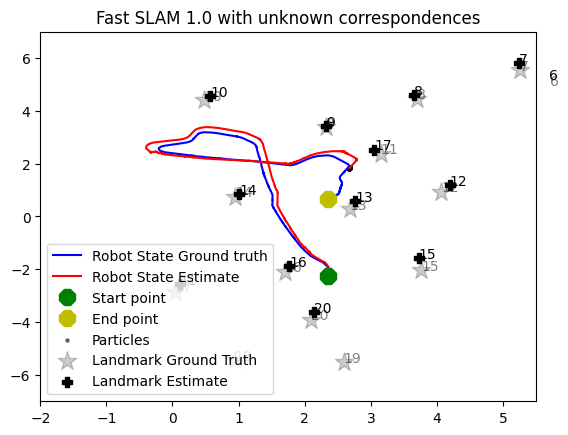

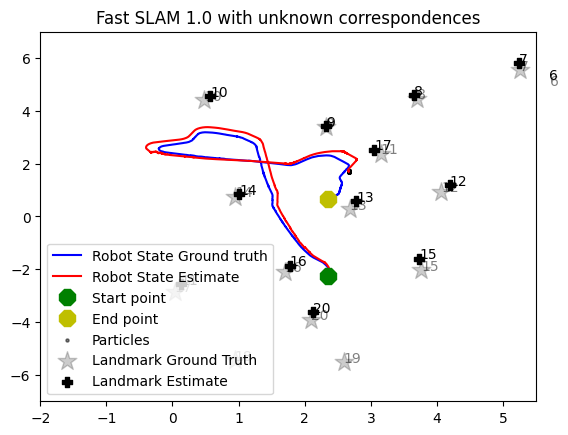

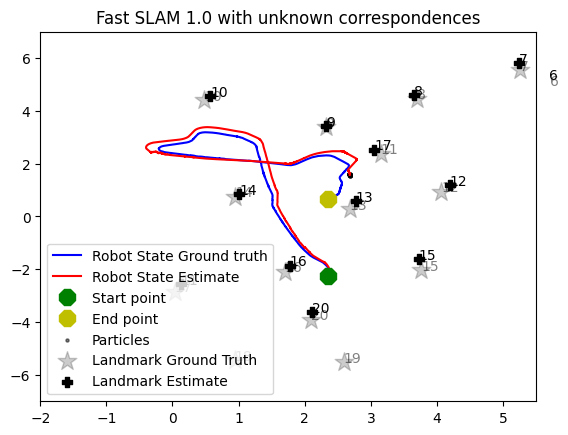

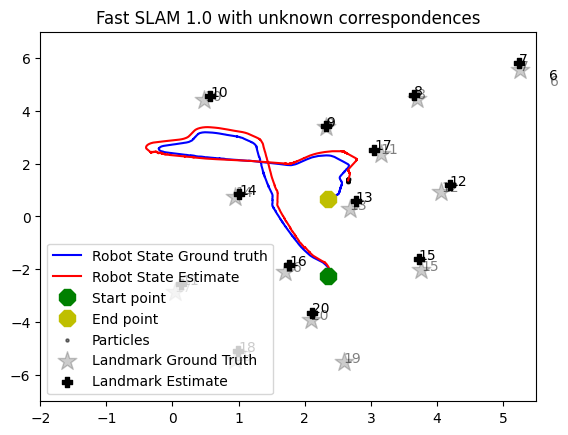

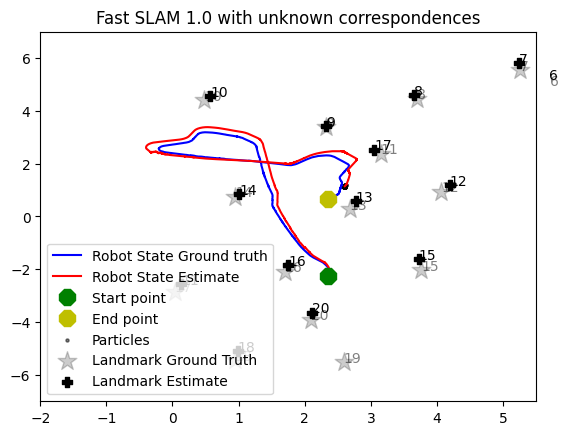

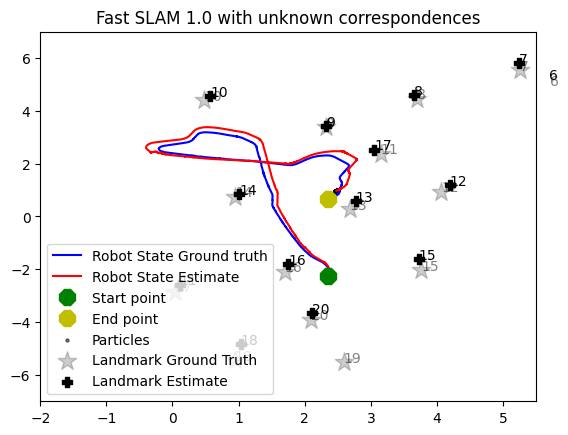

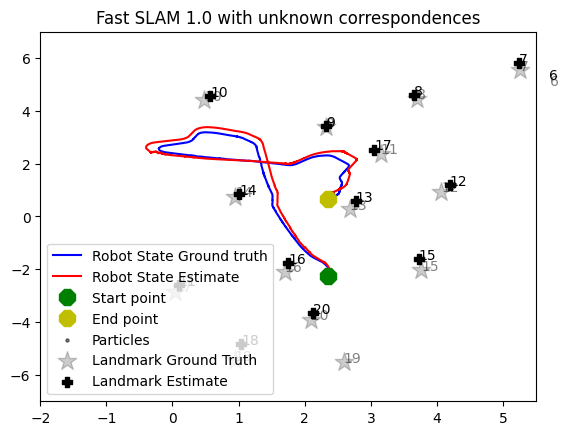

In [8]:
# Initialize Motion Model object
# Motion noise (in meters / rad)
# [noise_x, noise_y, noise_theta, noise_v, noise_w]
# Fisrt three are used for initializing particles
# Last two are used for motion update
motion_noise = np.array([0.0, 0.0, 0.0, 0.1, 0.15])
motion_model = FS1_MotionModel(motion_noise)

# Initialize Measurement Model object
# Measurement covariance matrix
Q = np.diagflat(np.array([0.05, 0.02])) ** 2
measurement_model = FS1_MeasurementModel(Q)

# Initialize SLAM algorithm
# Number of particles
N_particles = 100

fast_slam = FastSLAM1(motion_model, measurement_model)
fast_slam.load_data(dataset, robot, start_frame, end_frame)
fast_slam.initialization(N_particles)

# Run full Fast SLAM 1.0 algorithm
for data in fast_slam.data:
    if (data[1] == -1):
        fast_slam.robot_update(data)
    else:
        fast_slam.landmark_update(data)
    fast_slam.state_update()
    # Plot every n frames
    if (len(fast_slam.states) % 200 == 0):
        fast_slam.plot_data()
plt.show()


### T2. Execute Fast SLAM 2
Test different datasets and analyze the performance of the algorithm

In [ ]:
# Motion covariance matrix
R = np.diagflat(np.array([0.01, 0.01, 0.01])) ** 2
# Measurement covariance matrix
# Q = np.diagflat(np.array([0.02, 0.04])) ** 2
Q = np.diagflat(np.array([0.05, 0.10])) ** 2
# Motion noise (in meters / rad)
# [noise_x, noise_y, noise_theta, noise_v, noise_w]
# Fisrt three are used for initializing particles
# Last two are used for motion update
motion_noise = np.array([0.0, 0.0, 0.0, 0.1, 0.15])

# Initialize Motion Model object
motion_model = FS2_MotionModel(R, motion_noise)

# Initialize Measurement Model object
measurement_model = FS2_MeasurementModel(R, Q)

# Initialize SLAM algorithm
# Number of particles
N_particles = 50
fast_slam = FastSLAM2(motion_model, measurement_model)
fast_slam.load_data(dataset, robot, start_frame, end_frame)
fast_slam.initialization(N_particles)

# Run full Fast SLAM 2.0 algorithm
for data in fast_slam.data:
    if (data[1] == -1):
        fast_slam.robot_update(data)
    else:
        fast_slam.landmark_update(data)
    fast_slam.state_update()
    # Plot every n frames
    if (len(fast_slam.states) % 400 == 0):
        fast_slam.plot_data()
# fast_slam.plot_data()
plt.show()

### T3. Iterate over diferent datasets
We are interested in retrieving the error metrics for multiple datasets and represent them in order to asses the performance of both methods.

In [9]:
def normalized_path_error_optim(position_df):
    position = position_df.copy()
    position['x_delta'] = position["x_gt"].diff()
    position["y_delta"] = position["y_gt"].diff()
    position['x_delta'][0] = 0
    position['y_delta'][0] = 0
    position["weights"] = np.sqrt(position['x_delta']**2 + position["y_delta"]**2)
    position["path_error"] = np.sqrt(np.power(position["x_gt"] - position["x"], 2) + np.power(position["y_gt"] - position["y"], 2))
    position["e_path"] = (position["path_error"] * position["weights"]) / position["weights"].sum()

    e_path = position["e_path"].sum()
    e_max = np.max(position["path_error"])
    e_end = position["path_error"].iloc[-1]
    return e_path, e_max, e_end

In [10]:
fast_slam.build_dataframes()

In [14]:
joint_df = fast_slam.robot_states.join(fast_slam.gt, rsuffix='_gt').dropna()
joint_df.head()
print(joint_df.shape)

(699, 6)


In [15]:
joint_df.head()

x         y     theta      x_gt  \
stamp                                                                   
2009-07-22 14:18:27.744000000  2.354268 -2.237577  1.334700  2.354268   
2009-07-22 14:18:28.134000128  2.359591 -2.205002  1.470100  2.360470   
2009-07-22 14:18:28.174000128  2.359889 -2.202083  1.469493  2.360714   
2009-07-22 14:18:28.204999936  2.360061 -2.200378  1.469823  2.360755   
2009-07-22 14:18:28.266000128  2.360470 -2.196353  1.470075  2.362492   

                                   y_gt  theta_gt  
stamp                                              
2009-07-22 14:18:27.744000000 -2.237577    1.3347  
2009-07-22 14:18:28.134000128 -2.214044    1.3996  
2009-07-22 14:18:28.174000128 -2.212569    1.4114  
2009-07-22 14:18:28.204999936 -2.212183    1.4209  
2009-07-22 14:18:28.266000128 -2.208364    1.4581

In [16]:
normalized_path_error_optim(joint_df)

(0.12834849004639556, 0.366360474913886, 0.21785707619824626)

#### Generate metrics

In [17]:
datasets = ["data/MRCLAM_Dataset1",
            "data/MRCLAM_Dataset2",
            "data/MRCLAM_Dataset3",
            "data/MRCLAM_Dataset4"]
robots = ['Robot1',
          'Robot2',
          'Robot3',
          'Robot4']

errors = pd.DataFrame(columns=['dataset','robot','path_error','max_error','final_error'])
start_frame = 0
end_frame = 1000

for ds in datasets:
   for rob in robots:
        # Motion covariance matrix
        R = np.diagflat(np.array([0.01, 0.01, 0.01])) ** 2
        # Measurement covariance matrix
        # Q = np.diagflat(np.array([0.02, 0.04])) ** 2
        Q = np.diagflat(np.array([0.05, 0.10])) ** 2
        # Motion noise (in meters / rad)
        # [noise_x, noise_y, noise_theta, noise_v, noise_w]
        # Fisrt three are used for initializing particles
        # Last two are used for motion update
        motion_noise = np.array([0.0, 0.0, 0.0, 0.1, 0.15])

        # Initialize Motion Model object
        motion_model = FS2_MotionModel(R, motion_noise)

        # Initialize Measurement Model object
        measurement_model = FS2_MeasurementModel(R, Q)

        # Initialize SLAM algorithm
        # Number of particles
        N_particles = 50
        fast_slam = FastSLAM2(motion_model, measurement_model)
        fast_slam.load_data(ds, rob, start_frame, end_frame)
        fast_slam.initialization(N_particles)

        # Run full Fast SLAM 2.0 algorithm
        for data in fast_slam.data:
            if (data[1] == -1):
                fast_slam.robot_update(data)
            else:
                fast_slam.landmark_update(data)
            fast_slam.state_update()
        fast_slam.build_dataframes()
        joint_df = fast_slam.robot_states.join(fast_slam.gt, rsuffix = '_gt').dropna()
        e_path, e_max, e_end = normalized_path_error_optim(joint_df)
        errors.loc[-1] = [ds, rob, start_frame, end_frame, e_path, e_max, e_end]
        errors.index = errors.index + 1  # shifting index
        errors = errors.sort_index()

#### Represent metrics

In [ ]:
# Represent metrics for all experiments

#### Analize metrics

In [ ]:
# Analize the results and provide the mean error metrics across the experiments performed.